# 实验：车道线检测

## 一、实验内容
基于机器视觉对交通车道线进行实时检测，应用全卷积神经网络对车道线进行识别和定位，并对车道线识别结果进行可视化。

## 二、实验目标
1. 了解全卷积神经网络基本原理
2. 熟悉车道线检测的常规流程
3. 掌握车道线检测模型的使用方法


## 三、实验过程


### 3.0 数据集预处理

In [1]:
import moxing as mox
mox.file.copy_parallel("s3://obs-22spring/20181016_deepLearn/full_CNN_train.p","./full_CNN_train.p")
mox.file.copy_parallel("s3://obs-22spring/20181016_deepLearn/full_CNN_labels.p","./full_CNN_labels.p")

INFO:root:Using MoXing-v1.17.3-43fbf97f
INFO:root:Using OBS-Python-SDK-3.20.7


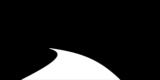

In [ ]:
import pickle as pl
import cv2
from IPython.display import clear_output, Image, display, HTML


def arrayShow(imageArray):
    ret, jpg = cv2.imencode('.jpg', imageArray)
    return Image(jpg)

#fr = open('full_CNN_train.p','rb')
fr = open('full_CNN_labels.p','rb')
images = pl.load(fr)
fr.close()

for img in images:
    clear_output(wait=True)
    display(arrayShow(img))
    k = cv2.waitKey(100)
    if( k & 0xff == ord('q')):
        break
cv2.waitKey(0)
cv2.destroyAllWindows()

print(len(images))

### 3.1 模型训练

首先导入需要的组件包，Numpy、keras、sklearn等，代码如下：

In [7]:
import keras
keras.__version__

'2.2.4'

In [1]:
import numpy as np
import pickle
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

# Import necessary items from Keras
from keras.models import Sequential
from keras.layers import Activation, Dropout, UpSampling2D
from keras.layers import Conv2DTranspose, Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras import regularizers

#https://github.com/mvirgo/MLND-Capstone

Using TensorFlow backend.
/home/ma-user/anaconda3/envs/TensorFlow-1.13-gpu/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/ma-user/anaconda3/envs/TensorFlow-1.13-gpu/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/ma-user/anaconda3/envs/TensorFlow-1.13-gpu/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qi

#### 1)模型结构定义
网络输入层为80 x 160 x 3（RGB）形状的道路图像，标签为80 x 160 x 1，只有G通道重新绘制车道，实现代码如下：

In [2]:
def create_model(input_shape, pool_size):
    # 创建网络模型
    model = Sequential()
    # 对输入层进行归一化处理
    model.add(BatchNormalization(input_shape=input_shape))

    # 卷积层1，名为Conv1
    model.add(Conv2D(8, (3, 3), padding='valid', strides=(1,1), activation = 'relu', name = 'Conv1'))

    # 卷积层2
    model.add(Conv2D(16, (3, 3), padding='valid', strides=(1,1), activation = 'relu', name = 'Conv2'))

    # 最大化层
    model.add(MaxPooling2D(pool_size=pool_size))

    # 卷积层3
    model.add(Conv2D(16, (3, 3), padding='valid', strides=(1,1), activation = 'relu', name = 'Conv3'))
    model.add(Dropout(0.2))

    # 卷积层4
    model.add(Conv2D(32, (3, 3), padding='valid', strides=(1,1), activation = 'relu', name = 'Conv4'))
    model.add(Dropout(0.2))

    # 卷积层5
    model.add(Conv2D(32, (3, 3), padding='valid', strides=(1,1), activation = 'relu', name = 'Conv5'))
    model.add(Dropout(0.2))

    # 最大化层2
    model.add(MaxPooling2D(pool_size=pool_size))

    # 卷积层6
    model.add(Conv2D(64, (3, 3), padding='valid', strides=(1,1), activation = 'relu', name = 'Conv6'))
    model.add(Dropout(0.2))

    # 卷积层7
    model.add(Conv2D(64, (3, 3), padding='valid', strides=(1,1), activation = 'relu', name = 'Conv7'))
    model.add(Dropout(0.2))

    # 最大化层3
    model.add(MaxPooling2D(pool_size=pool_size))

    # 上采样层1
    model.add(UpSampling2D(size=pool_size))

    # 反卷积层 1
    model.add(Conv2DTranspose(64, (3, 3), padding='valid', strides=(1,1), activation = 'relu', name = 'Deconv1'))
    model.add(Dropout(0.2))

    # 反卷积层 2
    model.add(Conv2DTranspose(64, (3, 3), padding='valid', strides=(1,1), activation = 'relu', name = 'Deconv2'))
    model.add(Dropout(0.2))

    # 上采样层 2
    model.add(UpSampling2D(size=pool_size))

    # 反卷积层 3
    model.add(Conv2DTranspose(32, (3, 3), padding='valid', strides=(1,1), activation = 'relu', name = 'Deconv3'))
    model.add(Dropout(0.2))

    # 反卷积层 4
    model.add(Conv2DTranspose(32, (3, 3), padding='valid', strides=(1,1), activation = 'relu', name = 'Deconv4'))
    model.add(Dropout(0.2))

    # 反卷积层 5
    model.add(Conv2DTranspose(16, (3, 3), padding='valid', strides=(1,1), activation = 'relu', name = 'Deconv5'))
    model.add(Dropout(0.2))

    # 上采样层 3
    model.add(UpSampling2D(size=pool_size))

    # 反卷积层 6
    model.add(Conv2DTranspose(16, (3, 3), padding='valid', strides=(1,1), activation = 'relu', name = 'Deconv6'))

    # 输出层
    model.add(Conv2DTranspose(1, (3, 3), padding='valid', strides=(1,1), activation = 'relu', name = 'Final'))

    return model

#### 2）加载数据

In [3]:
# 加载训练数据
train_images = pickle.load(open("full_CNN_train.p", "rb" ))

# 加载标签数据
labels = pickle.load(open("full_CNN_labels.p", "rb" ))

# 对数据进行预处理
train_images = np.array(train_images)
labels = np.array(labels)

# 对标签进行归一化处理
labels = labels / 255

# 混淆数据
train_images, labels = shuffle(train_images, labels)
# 划分训练集和测试集
X_train, X_val, y_train, y_val = train_test_split(train_images, labels, test_size=0.1)

print("loaded train samples:", len(train_images))

loaded train samples: 12764


#### 3）构建并编译模型

In [4]:
# 定义超参
#批大小
batch_size = 128
#训练回合数
epochs = 10
#池化大小
pool_size = (2, 2)
#输入大小
input_shape = X_train.shape[1:]

# 构建模型
model = create_model(input_shape, pool_size)

# 构建数据生成器实现通道增强
datagen = ImageDataGenerator(channel_shift_range=0.2)
datagen.fit(X_train)

# 编译模型
model.compile(optimizer='Adam', loss='mean_squared_error')
# 可视化模型
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_1 (Batch (None, 80, 160, 3)        12        
_________________________________________________________________
Conv1 (Conv2D)               (None, 78, 158, 8)        224       
_________________________________________________________________
Conv2 (Conv2D)               (None, 76, 156, 16)       1168      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 38, 78, 16)        0         
_________________________________________________________________
Conv3 (Conv2D)               (None, 36, 76, 16)        2320      
_________________________________________________________________
dropout_1 (Dropout)  

#### 4)训练模型

In [5]:
model.fit_generator(datagen.flow(X_train, y_train, batch_size=batch_size), steps_per_epoch=len(X_train)/batch_size,
epochs=epochs, verbose=1, validation_data=(X_val, y_val))

Instructions for updating:
Use tf.cast instead.
Epoch 1/10
90/89 [==============================] - 12s 128ms/step - loss: 0.0539 - val_loss: 0.0251
Epoch 2/10
90/89 [==============================] - 6s 70ms/step - loss: 0.0164 - val_loss: 0.0149
Epoch 3/10
90/89 [==============================] - 6s 68ms/step - loss: 0.0123 - val_loss: 0.0103
Epoch 4/10
90/89 [==============================] - 6s 69ms/step - loss: 0.0103 - val_loss: 0.0093
Epoch 5/10
90/89 [==============================] - 6s 68ms/step - loss: 0.0094 - val_loss: 0.0087
Epoch 6/10
90/89 [==============================] - 6s 68ms/step - loss: 0.0087 - val_loss: 0.0076
Epoch 7/10
90/89 [==============================] - 6s 68ms/step - loss: 0.0084 - val_loss: 0.0075
Epoch 8/10
90/89 [==============================] - 6s 68ms/step - loss: 0.0081 - val_loss: 0.0070
Epoch 9/10
90/89 [==============================] - 6s 68ms/step - loss: 0.0078 - val_loss: 0.0069
Epoch 10/10
90/89 [==============================] - 6s 67m

#### 5)保存模型

In [6]:
# Freeze layers since training is done
model.trainable = False
model.compile(optimizer='Adam', loss='mean_squared_error')

# Save model architecture and weights
model.save('full_CNN_model_tiny.h5')


### 3.2 加载并使用模型

#### 1） 加载Python相关组件

In [7]:
import numpy
import numpy as np
import cv2
from PIL.Image import Image
from keras.models import load_model
from IPython.display import clear_output, Image, display, HTML

#### 2）定义工具类

In [8]:
# 道路线类
class Lanes():
    def __init__(self):
        self.recent_fit = []
        self.avg_fit = []

In [9]:
#图像显示方法
def arrayShow(imageArray):
    ret, jpg = cv2.imencode('.jpg', imageArray)
    return Image(jpg)

#### 3）加载检测模型

In [14]:
# 加载模型full_CNN_model_tiny.h5
model = load_model('full_CNN_model_tiny.h5')

#### 4）读取视频文件和输出检测结果

读取input目录下的demo.mp4文件，逐帧读取并交给模型进行检测和识别，然后对检测结果计算其均值，并将检测结果绘制输出。

代码如下：

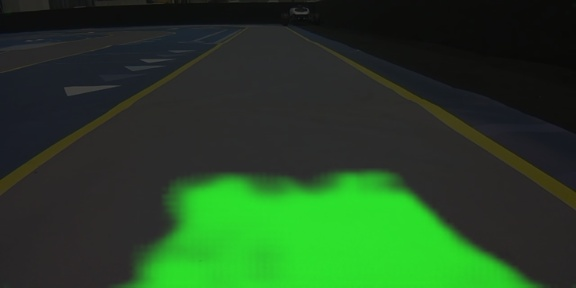

[INFO] cleaning up...


In [16]:
#读取视频文件
vs = cv2.VideoCapture("车道线视频.mp4")

frameIndex = 0

lanes = Lanes()

#循环读取
while True:
    #读取视频帧
    (grabbed, frame_source) = vs.read()
    if not grabbed:
        break
    
    #将视频帧resize为模型的输入大小
    frame_show = cv2.resize(frame_source, (576, 288))
    frame = cv2.resize(frame_show, (160, 80))


    rgb_small_frame = frame[None,:,:,:]

   
    # 模型推理检测
    prediction = model.predict(rgb_small_frame)[0] * 255

    # 储存预测结果到列表中
    lanes.recent_fit.append(prediction)
    # 只使用最近的数据
    if len(lanes.recent_fit) > 5:
        lanes.recent_fit = lanes.recent_fit[1:]

    # 计算平均预测结果
    lanes.avg_fit = np.mean(np.array([i for i in lanes.recent_fit]), axis = 0)

    # Generate fake R & B color dimensions, stack with G
    blanks = np.zeros_like(lanes.avg_fit).astype(np.uint8)
    lane_drawn = np.dstack((blanks, lanes.avg_fit, blanks))
    
    #恢复成原始视频大小
    lane_image = cv2.resize(lane_drawn, (576, 288))

    #合并原始图像和检测结果
    img = cv2.addWeighted(frame_show, 0.3, lane_image, 0.7, 0,dtype = cv2.CV_32F) 

    
    # 清空绘图空间
    clear_output(wait=True)
    
    # 显示处理结果
    display(arrayShow(img))

    #按键盘中的q键退出检测
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# 释放资源
print("[INFO] cleaning up...")
vs.release()
cv2.destroyAllWindows()


###### 上述的网络model在车道线检测的时候效果并不稳定，所以对其进行了改进。
###### 1.增加了网络的层数，修改了每层卷积核的个数。
###### 2.受Unet网络的启发，采用并联跳跃结构将encoding的feature map 与 decoding的feature map进行连接，这样可以在进行分类预测时利用多层信息。
###### 3.将UpSampling2D改为Conv2DTranspose实现上采样的过程，UpSampling2D直接采用原像素值进行填补不存在学习的过程，而Conv2DTranspose存在学习的过程，效果更好。

In [13]:
import numpy as np
import pickle
#import cv2
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
 
# Import necessary items from Keras
from keras.models import Model
from keras.layers import Activation, Dropout, UpSampling2D, concatenate, Input
from keras.layers import Conv2DTranspose, Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import plot_model
from keras import regularizers
 
# Load training images
train_images = pickle.load(open("full_CNN_train.p", "rb" ))
 
# Load image labels
labels = pickle.load(open("full_CNN_labels.p", "rb" ))
 
# Make into arrays as the neural network wants these
train_images = np.array(train_images)
labels = np.array(labels)
 
 
 
# Normalize labels - training images get normalized to start in the network
labels = labels / 255
 
# Shuffle images along with their labels, then split into training/validation sets
train_images, labels = shuffle(train_images, labels)
# Test size may be 10% or 20%
X_train, X_val, y_train, y_val = train_test_split(train_images, labels, test_size=0.1)
 
# Batch size, epochs and pool size below are all paramaters to fiddle with for optimization
batch_size = 16
epochs = 15
pool_size = (2, 2)
#input_shape = X_train.shape[1:]
 
### Here is the actual neural network ###
# Normalizes incoming inputs. First layer needs the input shape to work
#BatchNormalization(input_shape=input_shape)
Inputs = Input(batch_shape=(None, 80, 160, 3))
 
# Below layers were re-named for easier reading of model summary; this not necessary
# Conv Layer 1
Conv1 = Conv2D(16, (3, 3), padding='valid', strides=(1,1), activation = 'relu')(Inputs)
Bat1 = BatchNormalization()(Conv1)
 
# Conv Layer 2
Conv2 = Conv2D(16, (3, 3), padding='valid', strides=(1,1), activation = 'relu')(Conv1)
Bat2 = BatchNormalization()(Conv2)
 
# Pooling 1
Pool1 = MaxPooling2D(pool_size=pool_size)(Conv2)
 
# Conv Layer 3
Conv3 = Conv2D(32, (3, 3), padding = 'valid', strides=(1,1), activation = 'relu')(Pool1)
#Drop3 = Dropout(0.2)(Conv3)
Bat3 = BatchNormalization()(Conv3)
 
# Conv Layer 4
Conv4 = Conv2D(32, (3, 3), padding = 'valid', strides=(1,1), activation = 'relu')(Bat3)
#Drop4 = Dropout(0.5)(Conv4)
Bat4 = BatchNormalization()(Conv4)
 
# Conv Layer 5
Conv5 = Conv2D(32, (3, 3), padding='valid', strides=(1,1), activation = 'relu')(Bat4)
#Drop5 = Dropout(0.2)(Conv5)
Bat5 = BatchNormalization()(Conv5)
 
# Pooling 2
Pool2 = MaxPooling2D(pool_size=pool_size)(Bat5)
 
# Conv Layer 6
Conv6 = Conv2D(64, (3, 3), padding='valid', strides=(1,1), activation = 'relu')(Pool2)
#Drop6 = Dropout(0.2)(Conv6)
Bat6 = BatchNormalization()(Conv6)
 
# Conv Layer 7
Conv7 = Conv2D(64, (3, 3), padding='valid', strides=(1,1), activation = 'relu')(Bat6)
#Drop7 = Dropout(0.2)(Conv7)
Bat7 = BatchNormalization()(Conv7)
 
# Pooling 3
Pool3 = MaxPooling2D(pool_size=pool_size)(Bat7)
 
# Conv Layer 8
Conv8 = Conv2D(128, (3, 3), padding='valid', strides=(1,1), activation = 'relu')(Pool3)
#Drop8 = Dropout(0.2)(Conv8)
Bat8 = BatchNormalization()(Conv8)
 
# Conv Layer 9
Conv9 = Conv2D(128, (3, 3), padding='valid', strides=(1,1), activation = 'relu')(Bat8)
#Drop9 = Dropout(0.2)(Conv9)
Bat9 = BatchNormalization()(Conv9)
 
# Pooling 4
Pool4 = MaxPooling2D(pool_size=pool_size)(Bat9)
 
 
# Upsample 1 to Deconv 1
Deconv1 = Conv2DTranspose(128, (2, 2), padding='valid', strides=(2,2), activation = 'relu')(Pool4)
#Up1 = UpSampling2D(size=pool_size)(Pool4)
Mer1 = concatenate([Deconv1, Bat9], axis=-1)
 
# Deconv 2
Deconv2 = Conv2DTranspose(128, (3, 3), padding='valid', strides=(1,1), activation = 'relu')(Mer1)
DBat2 = BatchNormalization()(Deconv2)
 
# Deconv 3
Deconv3 = Conv2DTranspose(64, (3, 3), padding='valid', strides=(1,1), activation = 'relu')(DBat2)
DBat3 = BatchNormalization()(Deconv3)
 
# Upsample 2 to Deconv 4
Deconv4 = Conv2DTranspose(64, (2, 2), padding='valid', strides=(2,2), activation = 'relu')(DBat3)
#Up2 = UpSampling2D(size=pool_size)(DBat2)
Mer2 = concatenate([Deconv4, Bat7], axis=-1)
 
# Deconv 5
Deconv5 = Conv2DTranspose(64, (3, 3), padding='valid', strides=(1,1), activation = 'relu')(Mer2)
DBat5 = BatchNormalization()(Deconv5)
 
# Deconv 6
Deconv6 = Conv2DTranspose(32, (3, 3), padding='valid', strides=(1,1), activation = 'relu')(DBat5)
DBat6 = BatchNormalization()(Deconv6)
 
# Upsample 3 to Deconv 7
Deconv7 = Conv2DTranspose(32, (2, 2), padding='valid', strides=(2,2), activation = 'relu')(DBat6)
#Up3 = UpSampling2D(size=pool_size)(DBat4)
Mer3 = concatenate([Deconv7, Bat5], axis=-1)
 
# Deconv 8
Deconv8 = Conv2DTranspose(32, (3, 3), padding='valid', strides=(1,1), activation = 'relu')(Mer3)
DBat8 = BatchNormalization()(Deconv8)
 
# Deconv 9
Deconv9 = Conv2DTranspose(16, (3, 3), padding='valid', strides=(1,1), activation = 'relu')(DBat8)
DBat9 = BatchNormalization()(Deconv9)
 
# Deconv 10
Deconv10 = Conv2DTranspose(16, (3, 3), padding='valid', strides=(1,1), activation = 'relu')(DBat9)
DBat10 = BatchNormalization()(Deconv10)
 
# Upsample 4 to Deconv 11
Deconv11 = Conv2DTranspose(16, (2, 2), padding='valid', strides=(2,2), activation = 'relu')(DBat10)
#Up4 = UpSampling2D(size=pool_size)(DBat7)
Mer4 = concatenate([Deconv11, Bat2], axis=-1)
 
# Deconv 12
Deconv12 = Conv2DTranspose(16, (3, 3), padding='valid', strides=(1,1), activation = 'relu')(Mer4)
DBat12 = BatchNormalization()(Deconv12)
 
# Deconv 13
Deconv13 = Conv2DTranspose(8, (3, 3), padding='valid', strides=(1,1), activation = 'relu')(DBat12)
DBat13 = BatchNormalization()(Deconv13)
 
# Final layer - only including one channel so 1 filter
Final = Conv2DTranspose(1, (3, 3), padding='same', strides=(1,1), activation = 'relu')(DBat13)
 
### End of network ###
model = Model(inputs=Inputs, outputs=Final)
 
 
# Using a generator to help the model use less data
# Channel shifts help with shadows slightly
datagen = ImageDataGenerator(channel_shift_range=0.2)
datagen.fit(X_train)
 
# Compiling and training the model
model.compile(optimizer='Adam', loss='mean_squared_error')
model.fit_generator(datagen.flow(X_train, y_train, batch_size=batch_size), steps_per_epoch=len(X_train)/batch_size,
epochs=epochs, verbose=1, validation_data=(X_val, y_val))
 
# Freeze layers since training is done
model.trainable = False
model.compile(optimizer='Adam', loss='mean_squared_error')
 
# Save model architecture and weights
model.save('full_CNN_model_HYe15.h5')
 
# Show summary of model
model.summary()
#plot_model(model, to_file='model.png')
 

Epoch 1/15
718/717 [==============================] - 23s 32ms/step - loss: 0.0364 - val_loss: 0.0125
Epoch 2/15
718/717 [==============================] - 19s 26ms/step - loss: 0.0080 - val_loss: 0.0113
Epoch 3/15
718/717 [==============================] - 19s 26ms/step - loss: 0.0048 - val_loss: 0.0049
Epoch 4/15
718/717 [==============================] - 18s 26ms/step - loss: 0.0040 - val_loss: 0.0237
Epoch 5/15
718/717 [==============================] - 19s 26ms/step - loss: 0.0037 - val_loss: 0.0053
Epoch 6/15
718/717 [==============================] - 18s 26ms/step - loss: 0.0032 - val_loss: 0.0029
Epoch 7/15
718/717 [==============================] - 18s 26ms/step - loss: 0.0029 - val_loss: 0.0029
Epoch 8/15
718/717 [==============================] - 18s 26ms/step - loss: 0.0026 - val_loss: 0.0027
Epoch 9/15
718/717 [==============================] - 18s 26ms/step - loss: 0.0023 - val_loss: 0.0026
Epoch 10/15
718/717 [==============================] - 19s 26ms/step - loss: 0.002

ImportError: Failed to import `pydot`. Please install `pydot`. For example with `pip install pydot`.

## 四、实验总结

本实验基于深度学习算法进行交通车道检测，通过将视频信号进行分帧后交由模型进行检测车道位置信息，并通过图像合成将其检测结合与原视频帧合并可视化输出。